**Introduction**

This project focuses on the analysis of a social network built using data extracted from the Deezer platform in March 2020 via its public API. The dataset represents a network of users from various European countries, where nodes correspond to users and edges indicate mutual follower relationships. This dataset is particularly interesting for studying social interactions and network dynamics due to its real-world nature and the geographical distribution of the users.

The project’s goal was to explore the structural characteristics of the network by analyzing fundamental properties such as degree distribution and clustering. Advanced techniques were implemented to detect communities within the graph, compute centrality measures, and understand the role of specific nodes in the network.

Additionally, methods for missing link prediction and connection recommendation were developed using graph embedding techniques, combining machine learning tools with network representation models. This approach provided a comprehensive view of the network’s dynamics and laid the groundwork for applications such as personalized recommendation systems and the prediction of new interactions.

• To start I’ve imported all necessary libraries for data analysis, machine learning model building and result visualization, including tools to manage complex graphs with NetworkX and generate node embeddings with Node2Vec:

In [ ]:
# Basic imports
import numpy as np
import pandas as pd
import random
import scipy as sp

# Visualization and plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for graphs and Node2Vec
import networkx as nx
from node2vec import Node2Vec

# Machine Learning
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    RandomizedSearchCV,
    StratifiedKFold
)
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity  # Additional import

# Statistics and distributions
from scipy.stats import sem, loguniform, beta, uniform
from statsmodels.distributions.empirical_distribution import ECDF

• I load the Deezer dataset and build the graph while removing self-loops to ensure accurate network analysis:

In [ ]:
# Loading the Deezer dataset
deezer_graph = nx.from_pandas_edgelist(
    pd.read_csv('/Users/ettoreoteri/Desktop/deezer_europe_edges.csv'),
    source='node_1',
    target='node_2',
    create_using=nx.Graph()
)

In [ ]:
# Remove self-loops
deezer_graph.remove_edges_from(nx.selfloop_edges(deezer_graph))

print(deezer_graph)

**OUTPUT**: 

*Graph with 28281 nodes and 92752 edges*

• I export the graph in GEXF format to enable visual and interactive analysis in Gephi:

In [ ]:
# Export the graph to GEXF format
nx.write_gexf(deezer_graph, '/Users/ettoreoteri/Desktop/deezer_graph.gexf')

print("Graph exported in GEXF format. Now you can load it into Gephi.")

**OUTPUT**:

*Graph exported in GEXF format. Now you can load it into Gephi.*

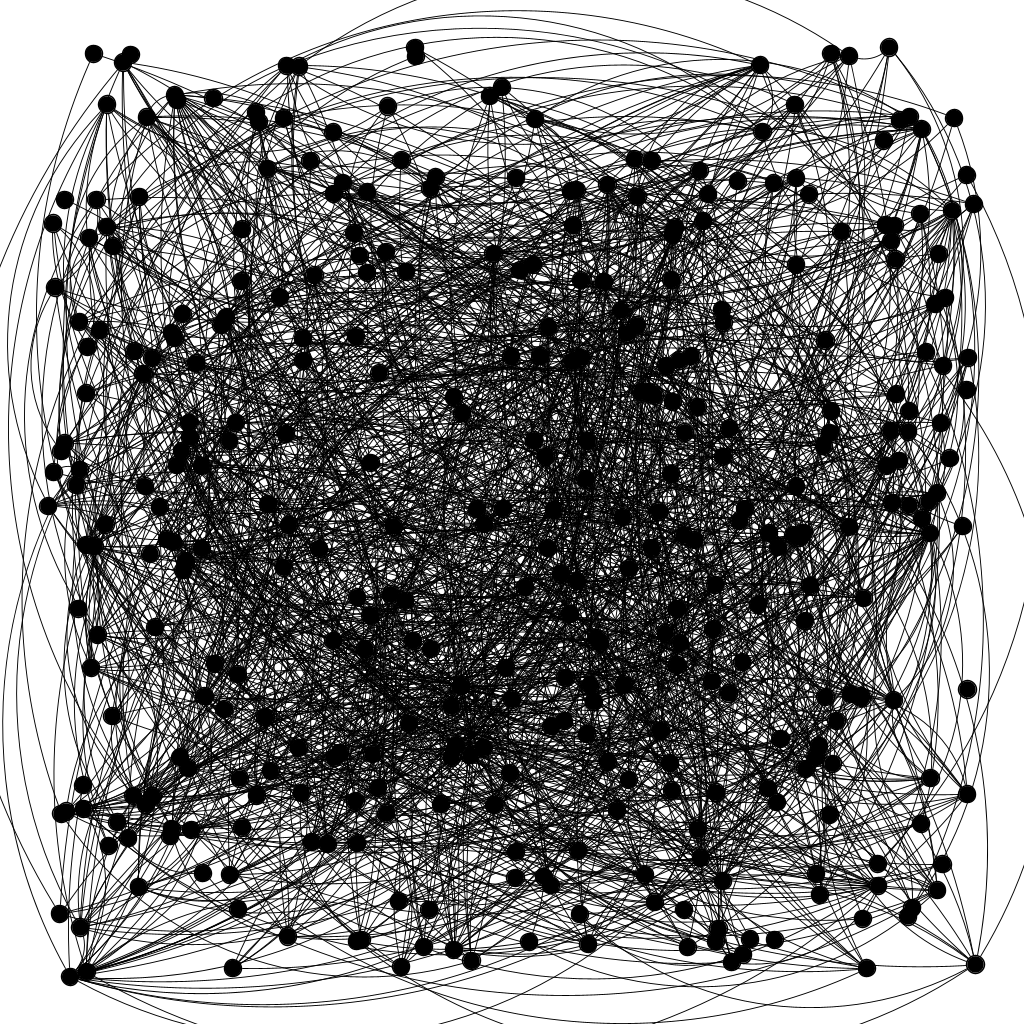

• I calculate the connected components, identify the largest one, and extract its subgraph to analyze the primary structure of the network:

In [ ]:
# Calculating connected components
components = list(nx.connected_components(deezer_graph))

# Total number of connected components
print(f"Number of connected components: {len(components)}")

# Identifying the largest connected component (LCC)
LCC = max(components, key=len)
giant_com_graph = deezer_graph.subgraph(LCC).copy()

# Information about the LCC
print(f"Number of nodes in the LCC: {giant_com_graph.number_of_nodes()}")
print(f"Number of edges in the LCC: {giant_com_graph.number_of_edges()}")

**OUTPUT**:

*Number of connected components: 1*

*Number of nodes in the LCC: 28281*

*Number of edges in the LCC: 92752*


• I compute the cumulative degree distribution of the graph and display it on a log-log plot to identify patterns or power-law behaviors in the network:

In [ ]:
# Degree calculation
degree_sample = list(dict(deezer_graph.degree()).values())

# Calculating the ECDF (Empirical Cumulative Distribution Function)
ecdf = ECDF(degree_sample)

# Coordinates for the cumulative distribution
x = np.unique(degree_sample)
y = ecdf(x)

# Plot of the cumulative distribution (log-log)
fig = plt.figure(figsize=(8, 4.5))
ax = fig.add_subplot()
ax.loglog(x, y, lw=4, ls='-', ms=7, marker='o', color='blue')
ax.set_xlabel('Degree $K$')
ax.set_ylabel('$P(K \leq k)$')
ax.set_title('Cumulative distribution of degrees (log-log)')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

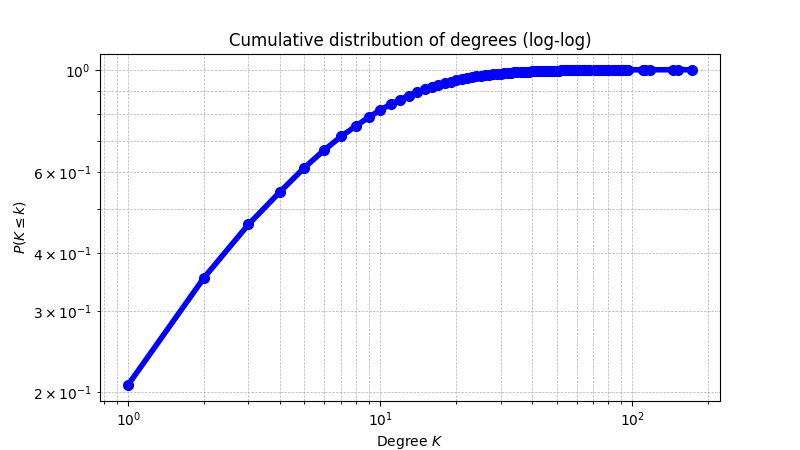

• We define hubs as nodes in the 95th percentile of degrees and analyze their connected components to study their structure within the network:

In [ ]:
# Calculating the threshold for hubs (95th percentile of degrees)
hub_threshold = np.percentile(degree_sample, 95)

# Identifying the hubs
hubs = {node for node, degree in deezer_graph.degree() if degree >= hub_threshold}

# Printing the hubs
print(f"Threshold for being a hub (95th percentile): {hub_threshold}")
print(f"Number of hubs identified: {len(hubs)}")

# Calculating the connected components of the hubs
hubs_ccs = len(list(nx.connected_components(deezer_graph.subgraph(hubs).copy())))

# Printing the number of connected components of the hubs
print(f"Number of connected components of the hubs: {hubs_ccs}")

**OUTPUT**:

*Threshold for being a hub (95th percentile): 21.0*

*Number of hubs identified: 1446*

*Number of connected components of the hubs: 43*

• I calculated the number of triangles per node in the network, built the empirical cumulative distribution, and displayed the result on a log-log plot to better visualize the distribution:

In [ ]:
# Extracting the number of triangles passing through each node
triangle_sample = nx.triangles(deezer_graph)

# Calculating the ECDF (Empirical Cumulative Distribution Function)
ecdf = ECDF(list(triangle_sample.values()))

# Coordinates for the cumulative distribution
x = np.unique(list(triangle_sample.values()))
y = ecdf(x)

# Plot of the cumulative distribution (log-log)
fig = plt.figure(figsize=(8, 4.0))
ax = fig.add_subplot()
ax.loglog(x, y, lw=4, ls='-', ms=7, marker='o', color='blue')
ax.set_xlabel('Number of triangles $\Delta$')
ax.set_ylabel('$P(\Delta \leq k)$')
ax.set_title('Cumulative distribution of the number of triangles (log-log)')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

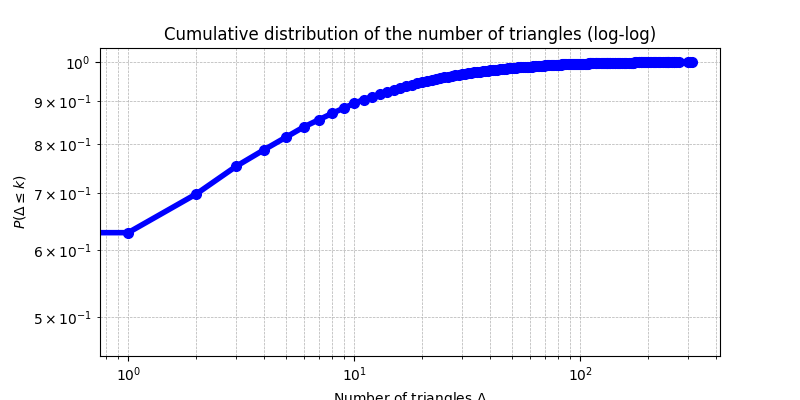

• I compared the triangle distribution in the Deezer graph with that generated by Erdős–Rényi random graphs, displaying the results on a log-log plot to highlight the differences between the two:

In [ ]:
# Parameters for the ER graph
N, p = deezer_graph.order(), nx.density(deezer_graph)

# Creating the plot
fig = plt.figure(figsize=(8, 4.0))
ax = fig.add_subplot()

# Extracting the triangle distribution from the original graph
triangle_sample = nx.triangles(deezer_graph)
ecdf = ECDF(list(triangle_sample.values()))
ax.loglog(ecdf.x, ecdf.y, lw=4, ls='-', ms=7, marker='o', color='blue', label='Deezer Graph')

# Generating random ER graphs and comparing distributions
for _ in range(10):
    g_rand = nx.fast_gnp_random_graph(N, p)
    triangle_sample_rand = nx.triangles(g_rand)
    ecdf_rand = ECDF(list(triangle_sample_rand.values()))
    ax.loglog(ecdf_rand.x, ecdf_rand.y, lw=2, ls='-', ms=7, marker='o', color='gray', alpha=0.5)

# Customizing the plot
ax.set_xlabel('Number of triangles $\Delta$')
ax.set_ylabel('$P(\Delta \leq k)$')
ax.set_title('Triangle distribution: Original Graph vs. Random ER graphs')
ax.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

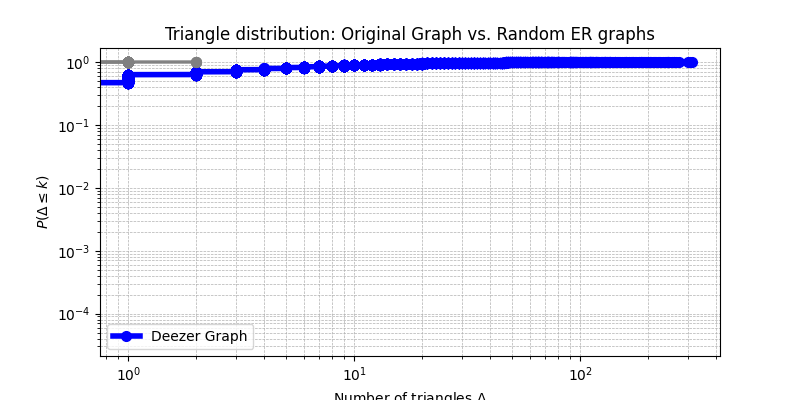

• In this code block, I calculated the connected components of the Deezer graph, identified the largest connected component (LCC), and created a subgraph containing only its nodes and edges. Finally, I printed some information about the number of components and the LCC:

In [ ]:
# Calculating connected components
components = list(nx.connected_components(deezer_graph))

# Identifying the Largest Connected Component (LCC)
LCC = max(components, key=len)

# Extracting the subgraph of the LCC
com_graph = deezer_graph.subgraph(LCC).copy()

# Printing graph information
print(f"Number of connected components: {len(components)}")
print(f"Number of nodes in the LCC: {com_graph.number_of_nodes()}")
print(f"Number of edges in the LCC: {com_graph.number_of_edges()}")

**OUTPUT**:

*Number of connected components: 1*

*Number of nodes in the LCC: 28281*

*Number of edges in the LCC: 92752*

• I calculated the empirical cumulative distribution of local clustering coefficients in the LCC and created a plot showing how local connectivity varies between nodes:

In [ ]:
# Distribution of the local clustering coefficient
clus_coef_sample = list(nx.clustering(com_graph).values())

# Calculating the ECDF
ecdf = ECDF(clus_coef_sample)

# Creating the plot
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.plot(ecdf.x, ecdf.y, lw=4, ls='-', ms=7, marker='o', color='blue')

# Customizing the plot
ax.set_xlabel('Clustering coefficient $cc$')
ax.set_ylabel('$P(CC \leq cc)$')
ax.set_title('Cumulative Distribution of Local Clustering Coefficient')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

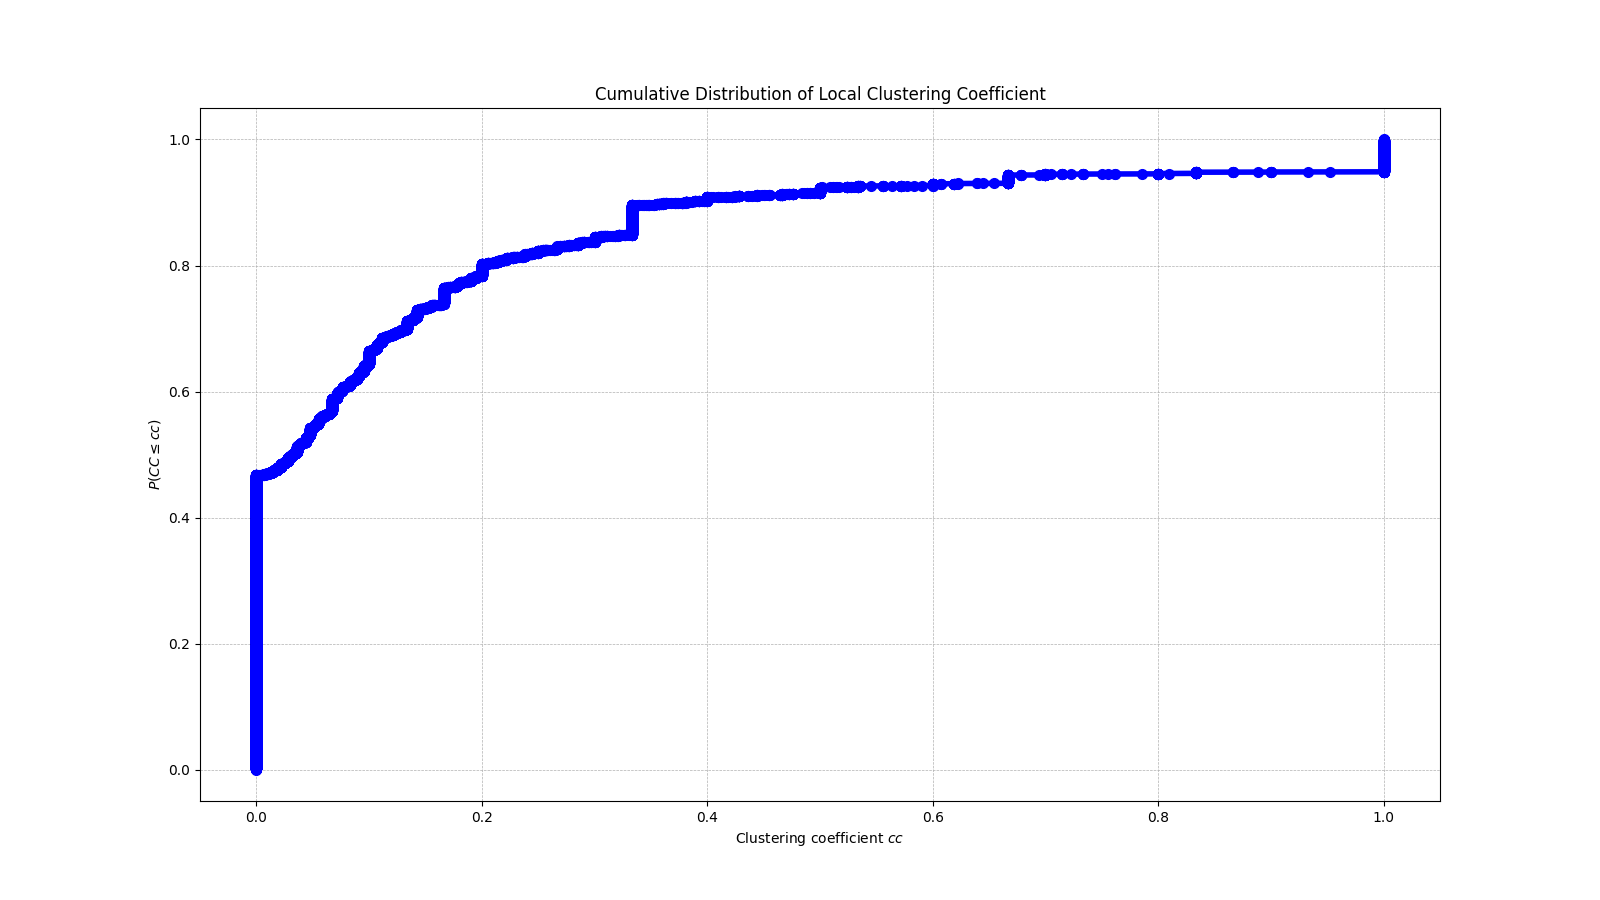

 • I computed the mean clustering coefficient of the LCC, which provides an overview of the overall level of cohesion between the nodes in the network:

In [ ]:
mean_clus_coef = np.mean(clus_coef_sample)
print(f"Mean Clustering Coefficient: {mean_clus_coef}")

**OUTPUT**:

*Mean Clustering Coefficient: 0.1411598733316564*

 • I created a scatter plot that relates the degree of each node to its clustering coefficient to explore how these parameters are distributed across the graph:

In [ ]:
# Calculating the degree and clustering for each node
degree_dict, cc_dict = dict(com_graph.degree()), nx.clustering(com_graph)

# Creating the degree and clustering lists
x, y = map(list, zip(*[(v, cc_dict[k]) for k, v in degree_dict.items()]))

# Creating the plot
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()

# Plotting the scatter plot
ax.scatter(x, y, alpha=0.3)

# Labeling the axes
ax.set_xlabel('Degree $k$')
ax.set_ylabel('Clustering Coefficient $cc$')

# Adding the title
ax.set_title('Degree vs Clustering Coefficient')

# Setting the grid
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Displaying the plot
plt.show()

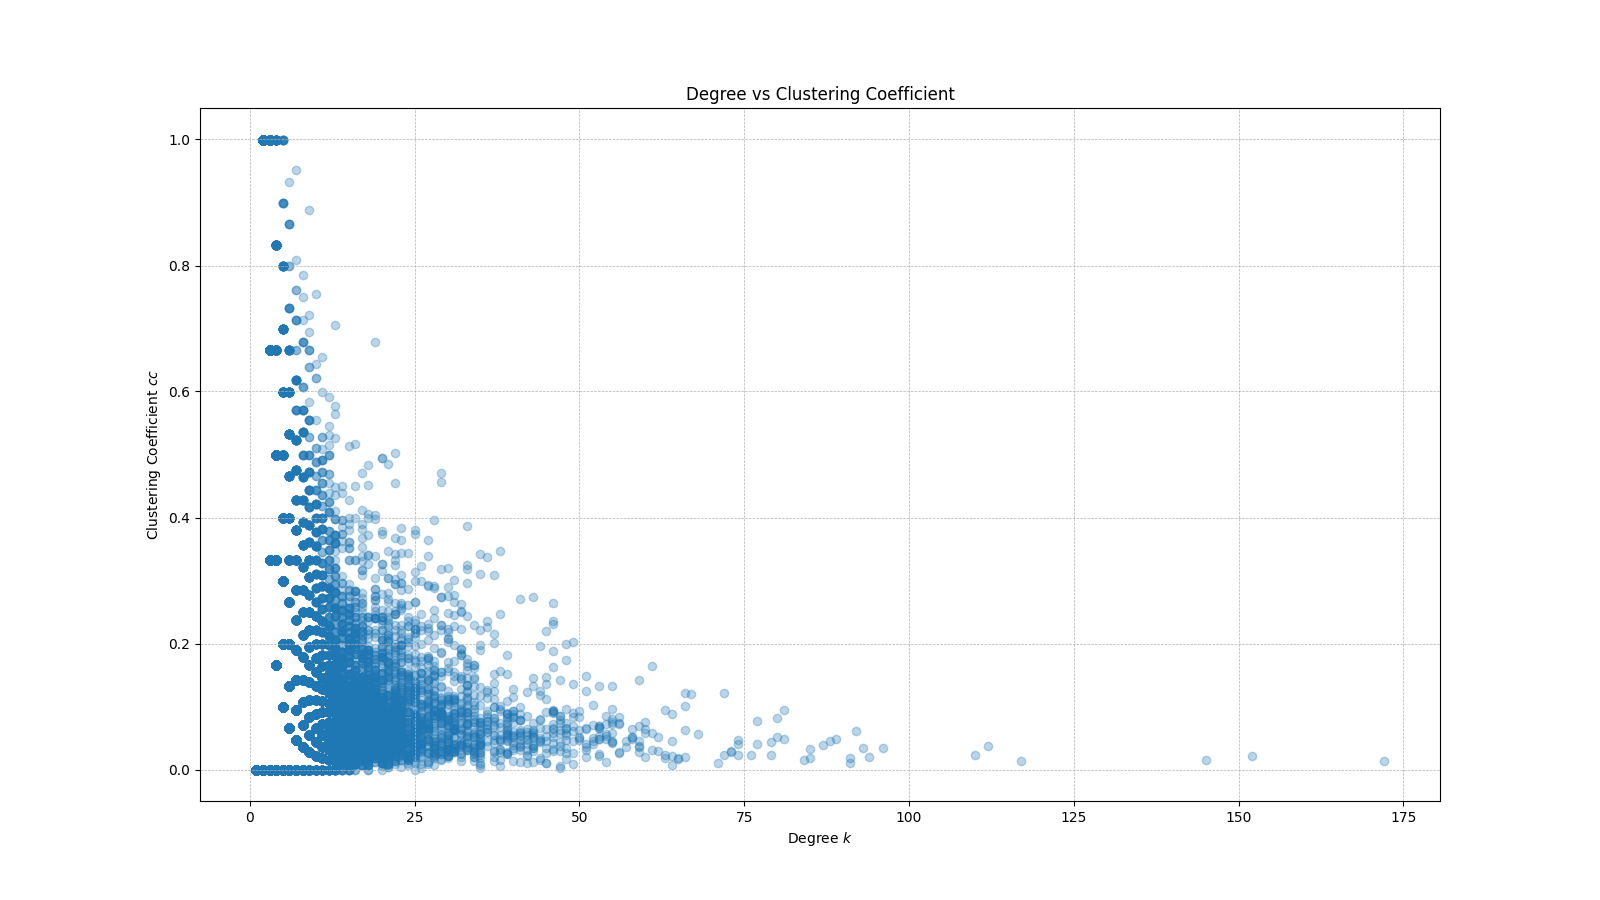

• I calculated several centrality measures (degree, betweenness, PageRank, eigenvector) for the Largest Connected Component. Then, I created a correlation matrix to analyze how these centralities are correlated with each other, visualizing it through a heatmap:

In [ ]:
# Extracting the largest connected component
largest_cc = max(nx.connected_components(deezer_graph), key=len)
subgraph = deezer_graph.subgraph(largest_cc).copy()

# Calculating centralities

# Approximate betweenness centrality (sampling 100 nodes)
betweenness_centrality = nx.betweenness_centrality(subgraph, k=100, seed=42)

# PageRank
pagerank = nx.pagerank(subgraph)

# Degree centrality
degree_centrality = nx.degree_centrality(subgraph)

# Eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(subgraph, max_iter=1000)

# Creating the DataFrame with all centralities
df_centrality = pd.DataFrame({
    'Degree': pd.Series(degree_centrality),
    'Eigenvector': pd.Series(eigenvector_centrality),
    'Betweenness': pd.Series(betweenness_centrality),
    'PageRank': pd.Series(pagerank)
})

# Calculating the correlation matrix (Kendall method)
corr = df_centrality.corr(method='kendall')

# Displaying the correlation matrix
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Correlation Matrix of Centrality Measures (LCC)')
plt.show()

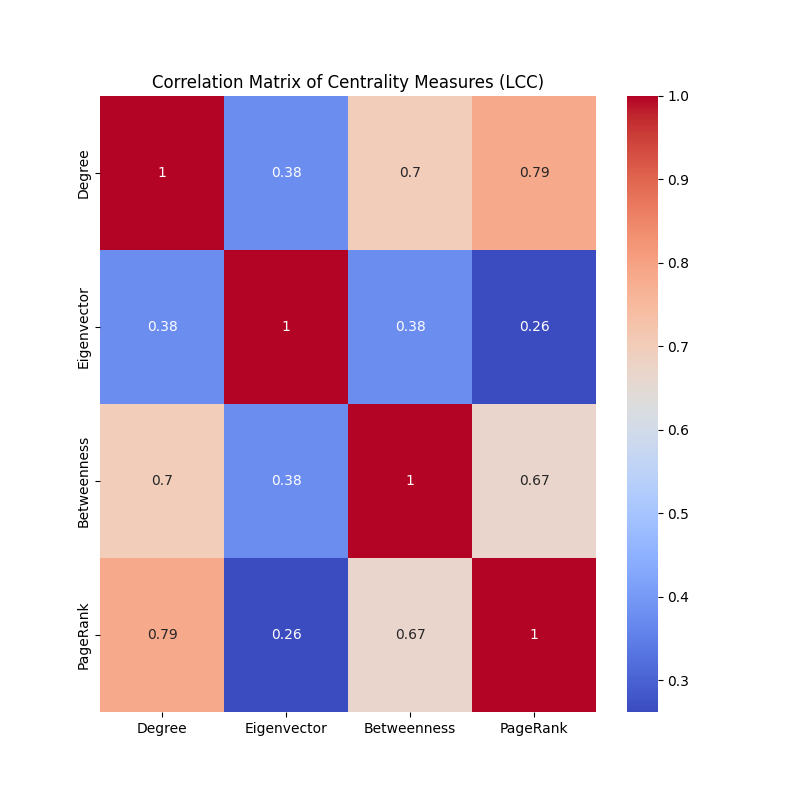

• I used the Louvain method to detect communities in the graph and then applied the Node2Vec algorithm to create node embeddings. With these embeddings, I performed K-means clustering to compare the detected communities. Finally, I evaluated the agreement between the Louvain and K-means partitions:

In [ ]:
# Community detection

# List of the graph's nodes
nodes_list = list(deezer_graph.nodes())
# Sampling to lighten the computation
nodes_list = nodes_list[:1000]

# Dictionary to store the communities
com4nodes = {n: {'lou': 0, 'clus': 0} for n in nodes_list}

# Community detection using Louvain (on a subgraph)
subgraph = deezer_graph.subgraph(nodes_list)
list_community_sets = nx.community.louvain_communities(subgraph)
for i, nodes in enumerate(list_community_sets):
    for node in nodes:
        com4nodes[node]['lou'] = i

# Node2Vec embedding
print("Generating Node2Vec embedding...")
node2vec = Node2Vec(
    subgraph,
    dimensions=10,
    walk_length=5,
    num_walks=50,
    p=1,
    q=1,
    workers=1
)
model = node2vec.fit(window=5, min_count=1, batch_words=2)
print("Node2Vec completed.")

# Creating the dataset for clustering
print("Creating embedding dataset for clustering...")
data_points = [model.wv[str(e)] for e in nodes_list]
print("Embedding dataset creation completed.")

# K-means clustering
print("Running K-means...")
kmeans = KMeans(n_clusters=len(list_community_sets), random_state=42, n_init='auto')
kmeans.fit(data_points)

# Updating the communities in the dictionary
for i, e in enumerate(nodes_list):
    com4nodes[e]['clus'] = kmeans.labels_[i]

# Evaluating the agreement between partitions
print("Calculating agreement between partitions...")
v_louvain = np.zeros(len(nodes_list))
v_clus = np.zeros(len(nodes_list))
for i, e in enumerate(nodes_list):
    v_louvain[i] = com4nodes[e]['lou']
    v_clus[i] = com4nodes[e]['clus']

**OUTPUT**:

*Generating Node2Vec embedding...*

*Node2Vec completed.*

*Creating embedding dataset for clustering...*

*Embedding dataset creation completed.*

*Running K-means...*

*Calculating agreement between partitions...*

• Here I calculated the normalized mutual information (NMI) score to evaluate how similar the partitions obtained by the Louvain and Node2Vec-KMeans methods are:

In [ ]:
# Calculating the normalized mutual information score
nmi_score = normalized_mutual_info_score(v_louvain, v_clus)
print(f"NMI between Louvain and Node2Vec-KMeans: {nmi_score}")

**OUTPUT**:

*NMI between Louvain and Node2Vec-KMeans: 0.7919088109164046*

• I prepared the data for the link prediction task, using the embeddings generated by Node2Vec. I also split the data into a training set and a test set to evaluate the model’s performance:

In [ ]:
# Node2Vec parameters
dimensions = 8
num_walks = 20
walk_length = 15
test_ratio = 0.2  # Test data percentage

# Graph sampling
sample_size = 2000
sampled_nodes = random.sample(list(deezer_graph.nodes()), min(sample_size, len(deezer_graph.nodes())))
subgraph = deezer_graph.subgraph(sampled_nodes)

# Generating embeddings with Node2Vec
node2vec = Node2Vec(
    subgraph, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, p=1, q=1, workers=1
)
model = node2vec.fit(window=4, min_count=1, batch_words=10)

# Creating the embedding matrix
embedding_matrix = np.array([model.wv[str(node)] for node in subgraph.nodes()])
X = embedding_matrix

# Extracting edges and non-edges for link prediction
list_edges = np.array([{u, v} for u, v in subgraph.edges()])
test_size = int(len(list_edges) * test_ratio)

# Generating positive and negative examples
positive_instances = [tuple(e) for e in np.random.choice(list_edges, replace=False, size=test_size)]
all_non_edges = np.array([{u, v} for u, v in nx.non_edges(subgraph)])
negative_instances = [tuple(e) for e in np.random.choice(all_non_edges, replace=False, size=test_size * 3)]  # 3 times the positives

# Dataset for link prediction
datapoints = positive_instances + negative_instances
dataset = [model.wv[str(u)] * model.wv[str(v)] for u, v in datapoints]
dataset_link_prediction = pd.DataFrame(dataset, columns=[f'Dim_{i}' for i in range(dimensions)])
dataset_link_prediction['label'] = [1] * len(positive_instances) + [0] * len(negative_instances)

# Train-test split
y = dataset_link_prediction.pop('label')
X = dataset_link_prediction

# Class management: Remove classes with less than 2 examples
class_counts = y.value_counts()
valid_classes = class_counts[class_counts >= 2].index
X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

print(f"Size of X (features): {len(X)}")
print(f"Size of y (labels): {len(y)}")

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30)

print(f"Number of examples in the training set: {len(X_train)}")
print(f"Number of examples in the test set: {len(X_test)}")

**OUTPUT**:

*Size of X (features): 356*

*Size of y (labels): 356*

*Number of examples in the training set: 267*

*Number of examples in the test set: 89*

• I used logistic regression to predict the links in the graph, and I evaluated the model’s performance using the F1 score on both the training and test sets:

In [ ]:
# Logistic Regression
model = LogisticRegression(random_state=30)
model.fit(X_train, y_train)

# Predictions and evaluation
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Printing results
print(f"F1 on training set: {f1_score(y_train, pred_train)}")
print(f"F1 on test set: {f1_score(y_test, pred_test)}")

**OUTPUT**:

*F1 on training set: 0.9925925925925926*

*F1 on test set: 0.9565217391304348*

• I created a recommendation function that, using node embeddings, calculates the cosine similarity between pairs of unconnected nodes, suggesting the top topk pairs with the highest similarity:

In [ ]:
# Creating the node-to-index mapping for the subgraph
node_to_index = {node: idx for idx, node in enumerate(subgraph.nodes())}

# Recommendation function
def recommend(embedding_matrix, pairs, node_to_index, topk=10):

    scores = []
    valid_pairs = []

    # Calculating cosine similarity only for valid pairs
    for u, v in pairs:
        if u in node_to_index and v in node_to_index:
            embedding_u = embedding_matrix[node_to_index[u]]
            embedding_v = embedding_matrix[node_to_index[v]]
            similarity = cosine_similarity(embedding_u.reshape(1, -1), embedding_v.reshape(1, -1))[0, 0]
            scores.append(similarity)
            valid_pairs.append((u, v))
    
    # Sorting pairs by similarity and selecting top-k
    top_k_indices = np.argsort(scores)[-topk:][::-1]
    top_pairs = [valid_pairs[i] for i in top_k_indices]
    top_scores = [scores[i] for i in top_k_indices]
    
    # Returning the pairs with their corresponding scores
    return list(zip(top_pairs, top_scores))

# Shuffling the non-edges
np.random.shuffle(all_non_edges)

# Using the function to recommend links
top_links = recommend(
    embedding_matrix=embedding_matrix,  # Pre-computed embedding matrix
    pairs=all_non_edges[:1000],  # Sample of 1000 non-edges
    node_to_index=node_to_index,  # Node-to-index mapping
    topk=10  # Number of recommendations
)

# Printing the results
print("Top-k recommendations with similarity scores:")
for i, (link, score) in enumerate(top_links):
    print(f"{i + 1}: {link} (score: {score:.4f})")

**OUTPUT**:

*Top-k recommendations with similarity scores:*

*1: (8145, 23615) (score: 0.9470)*

*2: (16098, 15516) (score: 0.8967)*

*3: (18626, 20301) (score: 0.8743)*

*4: (2457, 14063) (score: 0.8657)*

*5: (10034, 27967) (score: 0.8230)*

*6: (12256, 8284) (score: 0.8173)*

*7: (3102, 17335) (score: 0.8081)*

*8: (10939, 13923) (score: 0.7992)*

*9: (22228, 20756) (score: 0.7885)*

*10: (23987, 16414) (score: 0.7836)*